In [5]:
!wget http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data.gz

--2024-03-12 06:43:18--  http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data.gz
Resolving kdd.ics.uci.edu (kdd.ics.uci.edu)... 128.195.1.86
Connecting to kdd.ics.uci.edu (kdd.ics.uci.edu)|128.195.1.86|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18115902 (17M) [application/x-gzip]
Saving to: ‘kddcup.data.gz’

kddcup.data.gz      100%[===================>]  17.28M  21.8MB/s    in 0.8s    

2024-03-12 06:43:19 (21.8 MB/s) - ‘kddcup.data.gz’ saved [18115902/18115902]



![Stratified.jpeg](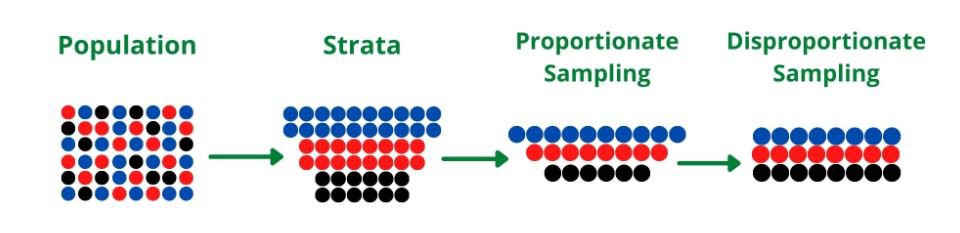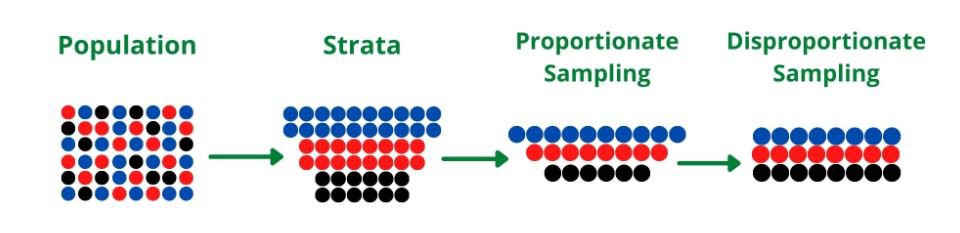)

In [41]:
!du -sh *



18M	kddcup.data.gz
55M	sample_data


In [2]:
import xgboost as xgb
import numpy as np
from collections import OrderedDict
import gc
from glob import glob
import os
import pandas as pd
from copy import copy
from time import time
from sklearn.metrics import roc_auc_score,confusion_matrix,accuracy_score,classification_report,roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from timeit import default_timer
import matplotlib.pyplot as plt
import pickle
from random import sample

In [6]:
col_names = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins","logged_in",
             "num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells","num_access_files","num_outbound_cmds",
             "is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
             "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate",
             "dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate",
             "dst_host_srv_rerror_rate","label"]

df =  pd.read_csv("kddcup.data.gz", header=None, names=col_names, index_col=False)

# Display the first few rows of the dataset
df.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.


In [7]:
df.shape

(4898431, 42)

In [36]:
df.label.value_counts()

smurf.              2807886
neptune.            1072017
normal.              972781
satan.                15892
ipsweep.              12481
portsweep.            10413
nmap.                  2316
back.                  2203
warezclient.           1020
teardrop.               979
pod.                    264
guess_passwd.            53
buffer_overflow.         30
land.                    21
warezmaster.             20
imap.                    12
rootkit.                 10
loadmodule.               9
ftp_write.                8
multihop.                 7
phf.                      4
perl.                     3
spy.                      2
Name: label, dtype: int64

# Random Sampling
Create a subset of 30 samples from the KDD99 population using Random Sampling method.
Random_state is for reproducible purpose

In [78]:
df.sample(n=30,random_state=123)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
3153442,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,smurf.
774715,0,tcp,http,SF,290,957,0,0,0,0,...,255,1.00,0.00,0.11,0.05,0.0,0.0,0.0,0.0,normal.
3482945,0,tcp,private,S0,0,0,0,0,0,0,...,6,0.02,0.06,0.00,0.00,1.0,1.0,0.0,0.0,neptune.
540212,0,tcp,private,S0,0,0,0,0,0,0,...,18,0.07,0.07,0.00,0.00,1.0,1.0,0.0,0.0,neptune.
991853,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,smurf.
3477219,0,tcp,private,S0,0,0,0,0,0,0,...,15,0.06,0.07,0.00,0.00,1.0,1.0,0.0,0.0,neptune.
4630339,0,tcp,private,REJ,0,0,0,0,0,0,...,5,0.02,0.07,0.00,0.00,0.0,0.0,1.0,1.0,neptune.
1519254,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,smurf.
3151237,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,smurf.
4376356,0,icmp,ecr_i,SF,520,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,smurf.


# Stratified Random Sampling
This technique involves 2 steps:
(1) Separate the Entire Population into Strata: based on similar characteristics, every member of the population must belong to exactly 1 stratum (singular strata)
(2) Randomly sampling each stratum


In [13]:
# note that for label, the corresponding percentage of each label are as below:
df.label.value_counts(normalize=True)*100

smurf.              57.322151
neptune.            21.884906
normal.             19.859032
satan.               0.324430
ipsweep.             0.254796
portsweep.           0.212578
nmap.                0.047280
back.                0.044974
warezclient.         0.020823
teardrop.            0.019986
pod.                 0.005389
guess_passwd.        0.001082
buffer_overflow.     0.000612
land.                0.000429
warezmaster.         0.000408
imap.                0.000245
rootkit.             0.000204
loadmodule.          0.000184
ftp_write.           0.000163
multihop.            0.000143
phf.                 0.000082
perl.                0.000061
spy.                 0.000041
Name: label, dtype: float64

Note that normal label only hold close to 20% of the entire population, while the smurf and neptune signal capture almost the rest.

## Proportionate Sampling
Next we will create a strata of 10% network type based on their labels, apply random sampling to select the packet

In [48]:
df10 = df.groupby("label").apply(lambda x: x.sample(frac=0.1,random_state=123))

In [49]:
df10.shape

(489842, 42)

10% of the KDD99 equivalent to 489k log files are sample. Using same random_state for reproducible purpose


In [50]:
df10.sample(500,random_state=123)

duration protocol_type  service flag  src_bytes  dst_bytes  \
label                                                                          
smurf.   3199212         0          icmp    ecr_i   SF       1032          0   
         496400          0          icmp    ecr_i   SF       1032          0   
neptune. 3652011         0           tcp  private   S0          0          0   
         3832378         0           tcp  private   S0          0          0   
smurf.   2007078         0          icmp    ecr_i   SF       1032          0   
...                    ...           ...      ...  ...        ...        ...   
neptune. 3904907         0           tcp  private   S0          0          0   
normal.  23969           0           tcp     http   SF        272       2261   
smurf.   435814          0          icmp    ecr_i   SF       1032          0   
         4841132         0          icmp    ecr_i   SF       1032          0   
         2528085         0          icmp    ecr_i   SF       1032          0   

                  land  wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
label                                                ...                       
smurf.   3199212     0               0       0    0  ...                 255   
         496400      0               0       0    0  ...                 255   
neptune. 3652011     0               0       0    0  ...                   8   
         3832378     0               0       0    0  ...                   2   
smurf.   2007078     0               0       0    0  ...                 255   
...                ...             ...     ...  ...  ...                 ...   
neptune. 3904907     0               0       0    0  ...                  25   
normal.  23969       0               0       0    0  ...                 255   
smurf.   435814      0               0       0    0  ...                 255   
         4841132     0               0       0    0  ...                 255   
         2528085     0               0       0    0  ...                 255   

                  dst_host_same_srv_rate  dst_host_diff_srv_rate  \
label                                                              
smurf.   3199212                    1.00                    0.00   
         496400                     1.00                    0.00   
neptune. 3652011                    0.03                    0.07   
         3832378                    0.01                    0.05   
smurf.   2007078                    1.00                    0.00   
...                                  ...                     ...   
neptune. 3904907                    0.10                    0.05   
normal.  23969                      1.00                    0.00   
smurf.   435814                     1.00                    0.00   
         4841132                    1.00                    0.00   
         2528085                    1.00                    0.00   

                  dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
label                                                                        
smurf.   3199212                          1.0                          0.0   
         496400                           1.0                          0.0   
neptune. 3652011                          0.0                          0.0   
         3832378                          0.0                          0.0   
smurf.   2007078                          1.0                          0.0   
...                                       ...                          ...   
neptune. 3904907                          0.0                          0.0   
normal.  23969                            0.0                          0.0   
smurf.   435814                           1.0                          0.0   
         4841132                          1.0                          0.0   
         2528085                          1.0                          0.0   

                  dst_host_serror_ra


## Disporportionate Sampling
This is rare in the real life data, however, certain cases applied.
For example, we want to sample 2 network packet of each label out of 4.9 million records

In [52]:
df2 = df.groupby("label").apply(lambda x: x.sample(2,random_state=123))

In [53]:
df2.shape

(46, 42)

In [54]:
df2.sample(20,random_state=123)


,,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
label,,,,,,,,,,,,,,,,,,,,,,
imap.,743329,41,tcp,imap4,SF,1334,162,0,0,0,0,...,5,1.00,0.00,0.20,0.00,0.40,0.40,0.00,0.00,imap.
ipsweep.,503324,0,icmp,eco_i,SF,8,0,0,0,0,0,...,255,1.00,0.00,1.00,0.50,0.00,0.00,0.00,0.00,ipsweep.
phf.,409912,0,tcp,http,SF,51,8127,0,0,0,2,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,phf.
portsweep.,3411378,0,tcp,private,REJ,0,0,0,0,0,0,...,1,0.00,1.00,1.00,0.00,0.00,0.00,1.00,1.00,portsweep.
neptune.,3470670,0,tcp,private,S0,0,0,0,0,0,0,...,7,0.03,0.07,0.00,0.00,1.00,1.00,0.00,0.00,neptune.
land.,744976,0,tcp,finger,S0,0,0,1,0,0,0,...,4,1.00,0.00,1.00,1.00,1.00,1.00,0.00,0.00,land.
perl.,41114,25,tcp,telnet,SF,269,2333,0,0,0,0,...,2,0.03,0.06,0.01,0.00,0.00,0.00,0.00,0.00,perl.
ipsweep.,1403103,0,icmp,eco_i,SF,8,0,0,0,0,0,...,46,1.00,0.00,1.00,0.52,0.00,0.00,0.00,0.00,ipsweep.
ftp_write.,394041,134,tcp,login,SF,100,39445,0,0,2,0,...,1,0.50,1.00,0.50,0.00,0.00,0.00,0.00,0.00,ftp_write.


Total 23 labels with 2 packet each are sampled for further analyses

# Cluster Sampling
In Cluster Sampling, every element of the population is selected equally.
The process involves 2 steps:
(1) Clusterize into N sub-groups or N clusters
(2) Select individual cluster created from Step (1) to perform next sampling (random sampling, stratified sampling, etc.)

In the example below, we create 10 clusters based on the labels (out of total 23 labels), and apply random sampling to the 10 clusters

In [31]:
list(df["label"].unique())

['normal.',
 'buffer_overflow.',
 'loadmodule.',
 'perl.',
 'neptune.',
 'smurf.',
 'guess_passwd.',
 'pod.',
 'teardrop.',
 'portsweep.',
 'ipsweep.',
 'land.',
 'ftp_write.',
 'back.',
 'imap.',
 'satan.',
 'phf.',
 'nmap.',
 'multihop.',
 'warezmaster.',
 'warezclient.',
 'spy.',
 'rootkit.']

In [46]:
select_clusters = sample(list(df["label"].unique()),k=10)

In [33]:
select_clusters

['ipsweep.',
 'back.',
 'multihop.',
 'satan.',
 'nmap.',
 'perl.',
 'warezmaster.',
 'guess_passwd.',
 'phf.',
 'normal.']

In [34]:
sampled_data = df[df["label"].isin(select_clusters)]

In [37]:
sampled_data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.


After having 10 different clusters, we randomly select 500 samples from these clusters

In [42]:
final_cluster = sampled_data.sample(500,random_state=123)

In [43]:
final_cluster

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
154565,0,tcp,http,SF,203,1046,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,normal.
4888705,0,tcp,http,SF,317,1856,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,normal.
282401,0,tcp,http,SF,243,1541,0,0,0,0,...,255,1.00,0.00,0.00,0.02,0.0,0.0,0.00,0.00,normal.
265990,0,tcp,smtp,SF,1087,306,0,0,0,0,...,76,0.16,0.77,0.01,0.03,0.0,0.0,0.73,0.01,normal.
4485415,0,tcp,smtp,SF,1516,328,0,0,0,0,...,162,0.64,0.02,0.00,0.00,0.0,0.0,0.00,0.00,normal.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393789,0,tcp,ftp_data,SF,305,0,0,0,0,0,...,38,0.17,0.02,0.17,0.00,0.0,0.0,0.00,0.00,normal.
4528295,0,udp,private,SF,105,147,0,0,0,0,...,233,0.91,0.01,0.00,0.00,0.0,0.0,0.00,0.00,normal.
231304,0,tcp,http,SF,242,824,0,0,0,0,...,94,1.00,0.00,0.03,0.05,0.0,0.0,0.00,0.00,normal.
744795,0,tcp,http,SF,233,1380,0,0,0,0,...,240,0.94,0.01,0.00,0.00,0.0,0.0,0.05,0.05,normal.
